# A4e Exploration
Finn Hittson - fxh157  
CSDS 464  
Due: April 13th, 2023

## Recap
For my research extension I am trying to build a beat detection system. This is an implementation of an algorithm proposed in the paper *Streamlined Tempo Estimation Based on Autocorrelation and Cross-correlation With Pulses*, written by Graham Percival and George Tazanetakis.  
In my previous progress report I had completed an implementation of the first step of the algorithm; generate onset signal strength (OSS). I also nearly completed the second part of the algorithm; beat period detection (BPD). The last step was not implemented at that time.

## A4e Progress
The biggest progression for this report is the completion of the final step of BPD, evaluating the pulse train, and the completion of the final step of the algorithm: accumulation and overall estimation. I will discuss each of these steps individually.  
  
#### BPD Pulse Train Evaluation
The final step of the BPD step of the overall algorithm is to evaluate the candidate tempos that were generated in the previous step, pick peaks. This step takes these tempo candidates and evaluates them by correlating the OSS signal with an ideal expected pulse train that is shifted by different time amounts. The ideal expected pulse train is defined as follows:  
Given the candidate tempo's, defined as $P$, let $\phi$ represent the phase location and $v=1,1.5,2$. Then the pulse train is generated using
$$
I_{P,\phi,v}=\phi+vBP\ \ \ B=0,1,2,3
$$
This generates three sequences, $I_{P,\phi,1}$, $I_{P,\phi,1.5}$, and $I_{P,\phi,2}$. All three of these sequences are then summed to get one sequence defined as $I_{p,\phi}$. See the diagrams below to see a visual representation of this process.

![](target_images/train1.jpeg)

![](target_images/train2.jpeg)

![](target_images/train3.jpeg)

![](target_images/combined.jpeg)

Then the combined $I_{P,\phi}$ is cross-correlated with the OSS frame for each phase $\phi=0,1,...,P-1$. The highest correlating phase is kept and the two scoring functions are defined below are calcualted on the highest correlations.
$$
SC_v(P,m)=\text{var}_\phi(\rho_P(\phi,m))
$$
$$
SC_x(P,m)=\max_\phi(\rho_P(\phi,m))
$$
Then the final score is computed by
$$
SC(P,m)=\frac{SC_x(P,m)}{\sum_cSC_x(P,m)}+\frac{SC_v(P,m)}{\sum_cSC_v(P,m)}
$$
Then the highest scoring lag tempo candidate is selected by 
$$
L_m=\argmax_PSC(P,m)
$$
This step was completed, see demonstration below.

#### Accumulation and overall estimate
The final step of the algorithm is to accumulate all tempo estimations and use this data to make an overall estimate. It is composed of three steps.
1. Convert to Gaussian: Since most tempo fluctuates throughout the song, a Gaussian curve is used to account for this. Instead of accumulating a single value for the tempo lag candidate a Gaussian defined by the following equation where $\sigma=10$ and $\mu=L_m$, is used to smooth these estimates.
$$
G_m=\frac{1}{\sigma\sqrt{2\pi}}e^{-(x-\mu)^2/2\sigma^2}
$$

2. Accumulator (sum): $G_m$ is calcualted for each frame and each $G_m$ is summed to get one Gaussian.

3. Pick peak: Pick the index that has the highest corresponding peak in the resulting sum of Gaussians. This will correspond to the overall estimate of tempo for the input signal.

These steps were implemented and are demonstrated below.

## Next Steps
I am still stuck on the flux calculation. I have located the authors code source so what I am going to do next is compare my implementation to theirs and see how it differs. This will hopefully lead me to the errors in mine and fix issues that will help my code produce the correct output and make accurate tempo estimates. 

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import numpy as np
import math
import IPython

import OSS as oss
import BPD as bpd
import plotters
import accumulate as acc

### Step 1: OSS

#### 1. Overlap

In [2]:
filepath = "ballroom.wav"
sr, data = oss.read_wav(filepath)
print(f"sampling rate: {sr}Hz")
print(f"audio length: {round(len(data)/sr, 3)} seconds")
IPython.display.Audio(filepath)

sampling rate: 44100Hz
audio length: 31.788 seconds


calculated frame count: 10950 frames
returned frame count: 10950 frames
(10950, 256)


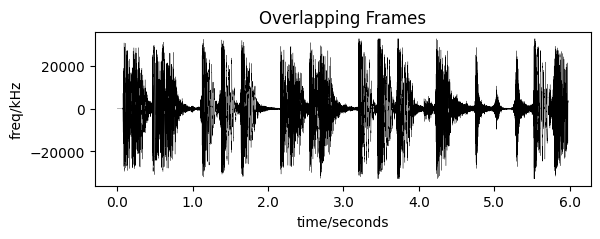

In [3]:
framesize = 256
hop = 128
print(f"calculated frame count: {1+math.floor((len(data)-framesize)/hop)} frames")
frames = oss.get_frames(data=data, framesize=framesize, hop=hop)
print(f"returned frame count: {len(frames)} frames")
frames6 = frames[:2059]
print(frames.shape)
plotters.plot_frames(frames=frames6, sr=44100, framesize=1024, hop=128, title="Overlapping Frames")

Target plot for overlap.  
  
![](target_images/overlap_oss.jpg)

#### 2. Log power spectrum

In [4]:
tappered_frames = oss.hamming_window(frames)
tappered_frames6 = oss.hamming_window(frames6)
# compute the discrete fourier transform of the frames
fft_frames = scipy.fft.fft(tappered_frames, n=framesize, axis=1)
fft_frames6 = scipy.fftpack.fft(x=tappered_frames6, n=framesize, axis=1)

In [5]:
log_power = np.array(oss.comp_log_power(fft_frames))
log_power6 = np.array(oss.comp_log_power(fft_frames6))

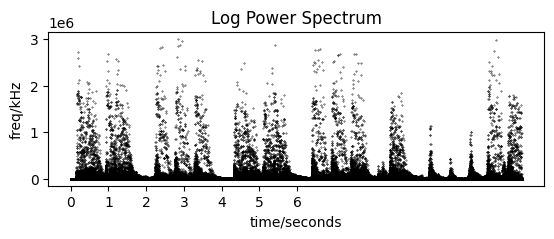

In [6]:
plotters.plot_log_spectrum(abs(fft_frames6), framesize=framesize, hop=hop, sr=44100)

#### 3. Flux

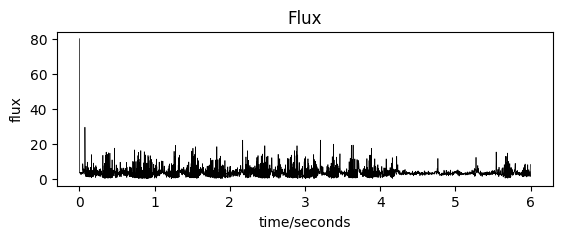

In [7]:
flux = oss.comp_flux(log_power)
flux6 = oss.comp_flux(log_power6)
plotters.plot_flux(flux6)

Target plot for Log Power Spectrum.  
  
![](target_images/log_power_spectrum_oss.jpg)

#### 4. Low-pass Filter

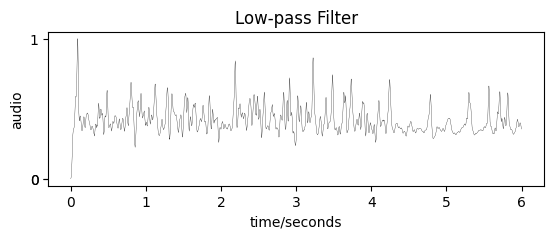

In [8]:
filtered_signal = oss.low_pass_filter(flux=flux)
filtered_signal6 = oss.low_pass_filter(flux=flux6)
plotters.plot_signal(filtered_signal6, sr=344.5, title="Low-pass Filter")

Target plot for Flux.  
  
![](target_images/flux_oss.jpg)

### Step 2: Beat Period Detection

#### 1. Overlap

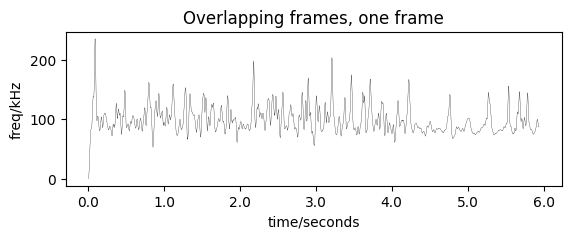

In [9]:
frames = bpd.overlap(data=filtered_signal, framesize=2048, hop=128)
plotters.plot_frames(frames=frames[0], sr=344.5, framesize=2048, hop=128, title="Overlapping frames, one frame")

Target plot for Overlap.  
  
![](target_images/overlap_bpd.jpg)

#### 2. Generalized Autocorrelation

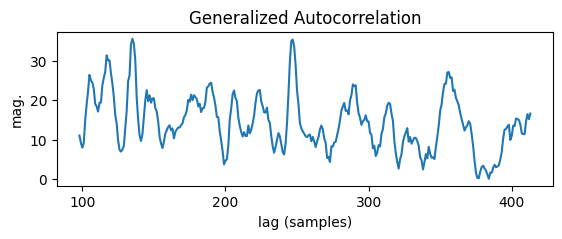

In [10]:
A = bpd.autocorrelation(signal=frames)
plotters.plot_correlation(A=A[0], title="Generalized Autocorrelation")

Target plot for Generalized Autocorrelation.  
  
![](target_images/generalized_autocorrelation_bpd.jpg)

#### 3. Enhance Harmonics

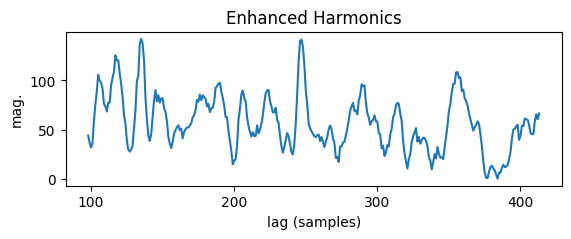

In [11]:
EAC = bpd.enhance_harmonics(A=A)
plotters.plot_correlation(A=EAC[0], title="Enhanced Harmonics")

Target plot for Enhanced Harmonics.  
  
![](target_images/enhance_harmonics_bpd.jpg)

#### 4. Pick Peaks

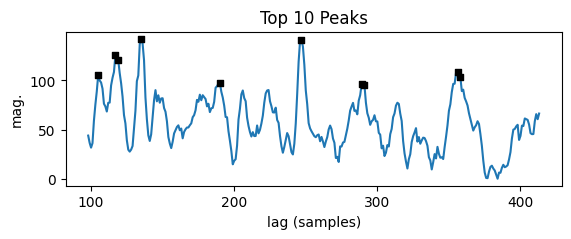

In [12]:
indices, values = bpd.pick_peaks(A=A)
idx = 0
plotters.plot_correlation(A=A[0], start=98+316*idx, stop=414+316*idx, indices=indices[idx], values=values[idx], title="Top 10 Peaks")

Target plot for Pick Peaks.  
  
![](target_images/pick_peaks_bpd.jpg)

In [13]:
Lm = bpd.evaluate_pulse_train(indices[0], frames[0])
print(f"{int(round(344.5*60/Lm, 0))} bpm")

559 bpm


### Step 3: Accumulation and overall estimate

#### 1. Convert to Gaussian

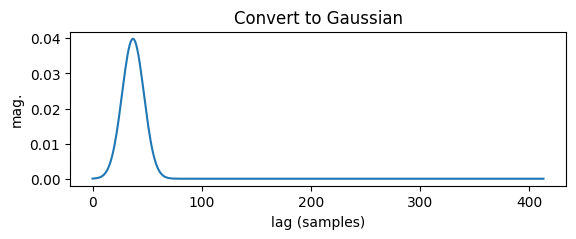

In [14]:
plotters.plot_gaussian(Lm=Lm, g=acc.Gm, title="Convert to Gaussian")

![](target_images/convert_to_gaussian.jpg)

#### Accumulate

c:\Users\hitts\Dropbox\PC\Documents\GitHub\beat\src\BPD.py:85: RuntimeWarning: invalid value encountered in divide
  return SCv/np.linalg.norm(SCv), SCx/np.linalg.norm(SCx)


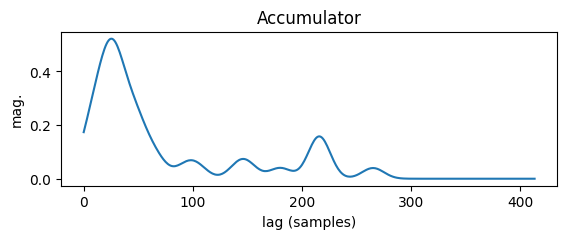

In [15]:
Lms = acc.eval_entire_signal(indices, frames)
y = acc.accumulate_gauss(Lms=Lms)
plotters.plot_gaussian(Lm=y, g=acc.Gm, title="Accumulator")

![](target_images/accumulate.jpg)

#### Pick peak

In [16]:
idxs, vals = bpd.find_local_maximums(np.concatenate((np.zeros(98), y[98:])))
print(f"overall estimate: {int(round(344.5*60/idxs[-1], 0))} bpm")

overall estimate: 96 bpm
